In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from src.plots import plot_regression
from tueplots import bundles
import scipy.stats as ss

In [3]:
rent_fs = pd.read_csv('../data/rent_federal_states.csv', index_col=0)

In [162]:
year_feature = rent_fs.index.values.reshape(-1 ,1)

coefs = []
mses = []
predictions = []

for fs in rent_fs.columns:
    
    observation = rent_fs.loc[:, fs].values

    fit = LinearRegression().fit(year_feature, observation)
    prediction = fit.predict(year_feature)
    predictions.append(prediction)

    coef = fit.coef_
    coefs.append(coef.item())

    mse = np.mean((observation - prediction)**2)
    mses.append(mse)

check if regression seems reasonable for all federal states by plotting the federal state prediction with largest mse

federal state with worst prediction:  Bremen


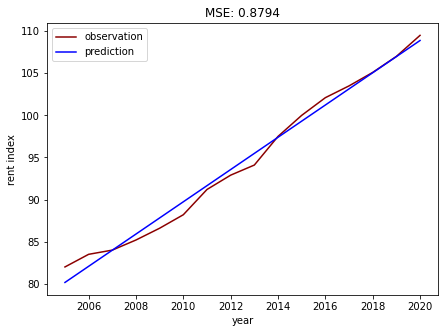

In [163]:
worst_pred_idx = np.argmax(mses)
print('federal state with worst prediction: ', rent_fs.columns[worst_pred_idx])
plot_regression(rent_fs.iloc[:, worst_pred_idx], predictions[worst_pred_idx], year_feature, 'MSE: ' + str(round(mses[worst_pred_idx], 4)))

The prediction seems to capture the slope of the rent development quite well.

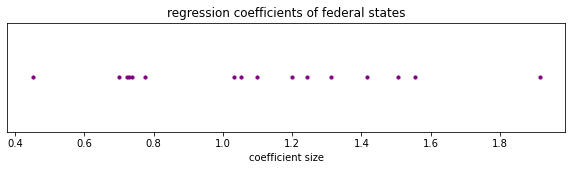

In [164]:
plt.figure(figsize=(10, 2))
plt.scatter(coefs, np.zeros((16,)), s=10, color='purple')
plt.tick_params(left=False, labelleft=False)
plt.xlabel('coefficient size')
plt.title('regression coefficients of federal states');

One coefficient one the left as well as one on the right look like outliers. It might be interesting to check if they differ significantly from the other coefficients.

In [165]:
coef_min_idx = np.argmin(coefs)
print('federal state with smallest coefficient: ', rent_fs.columns[coef_min_idx])
coef_max_idx = np.argmax(coefs)
print('federal state with largest coefficient: ', rent_fs.columns[coef_max_idx])

federal state with smallest coefficient:  Sachsen
federal state with largest coefficient:  Bremen


Compute the maximum likelihood parameters for all coefficients but the smallest and largest one.

In [168]:
ncoefs = coefs.copy()
coef_min = ncoefs.pop(coef_min_idx)
coef_max = ncoefs.pop(coef_max_idx)
coef_mean = np.mean(ncoefs)
coef_std = np.std(ncoefs)
xrange = np.arange(0.4, 2, 0.05)
coef_norm = ss.norm(loc=coef_mean, scale=coef_std)
coef_pdf = coef_norm.pdf(xrange)

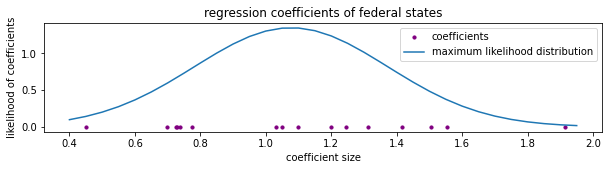

In [173]:
plt.figure(figsize=(10, 2))
plt.scatter(coefs, np.zeros((16,)), s=10, color='purple', label='coefficients')
plt.xlabel('coefficient size')
plt.ylabel('likelihood of coefficients')
plt.plot(xrange, coef_pdf, label='maximum likelihood distribution')
plt.legend()
plt.title('regression coefficients of federal states');

In [170]:
print(f'Probability for a coefficient <= {np.round(coef_min, 4)}: {np.round(coef_norm.cdf(coef_min), 4)}')
print(f'Probability for a coefficient >= {np.round(coef_max, 4)}: {np.round(1 - coef_norm.cdf(coef_max), 4)}')
print(f'P-values for two-sided test: {np.round(coef_norm.cdf(coef_min)*2, 4)} and {np.round((1 - coef_norm.cdf(coef_max))*2, 4)}')

Probability for a coefficient <= 0.4507: 0.017
Probability for a coefficient >= 1.9153: 0.0023
P-values for two-sided test: 0.034 and 0.0046


For a significance level $\alpha$ = 0.05, both coefficients have significant p-values assuming a normal distribution with maximum likelihood parameters over all other coefficients. However, when applying the bonferri correction only the largest coefficient remains significant.   

#### save relevant figures to fig

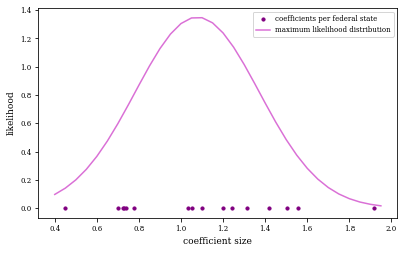

In [178]:
with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):

    #plt.figure(figsize=(10, 2))
    plt.scatter(coefs, np.zeros((16,)), s=10, color='purple', label='coefficients per federal state')
    plt.xlabel('coefficient size')
    plt.ylabel('likelihood')
    plt.plot(xrange, coef_pdf, color='orchid', label='maximum likelihood distribution')
    plt.legend()

plt.savefig('../fig/coefs_exp_05.pdf', bbox_inches='tight')